# ProVaksin Sentiment Labelling

*   Sebelum memulai running pastikan data path sudah disesuaikan
*   Mungkin masih terdapat beberapa baris yang akan menimbulkan error, bisa diabaikan lanjut ke tahap selanjutnya.
*   Bila terdapat kesulitan dapat menghubungi Farrel Via WA (081331013216)

#Environment (Run)

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  | Proc size: 118.3 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [ ]:
#import library
import numpy as np
import pandas as pd

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
#import torch and check cuda
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.3 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


#Dataset (Don't Run It)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_excel('/content/drive/MyDrive/penelitian/data5/data label fix/train_new/train_jenisvaksin.xlsx').drop(['Unnamed: 0'],axis=1)
df_train1 = df_train[:3000].drop(['NEUTRAL','POSITIVE','NEGATIVE'], axis=1)
df_train2 = df_train[3000:].drop(['response'],axis=1)
df_train2

,id,date,username,tweet,replies_count,retweets_count,likes_count,link,tweet_preprocessed,labels,NEUTRAL,POSITIVE,NEGATIVE
3000,1416283768197763072,2021-07-17,effendisimbolo3,@adearmando1 Vaksinasi segera dikebut secepatn...,0,0,0,https://twitter.com/effendisimbolo3/status/141...,adearmando1 vaksinasi segera dikebut secepatny...,jenis,0,1,0
3001,1419855062063534080,2021-07-27,keepodotme,"Inilah Perbedaan Vaksin Sinovac, Astrazeneca, ...",0,3,0,https://twitter.com/KeepoDotMe/status/14198550...,inilah perbedaan vaksin sinovac astrazeneca mo...,jenis,1,0,0
3002,1418526310456978944,2021-07-23,reborn21s,Saya sih lebih percaya vaksin Nusantara buatan...,1,0,0,https://twitter.com/Reborn21s/status/141852631...,sih lebih percaya vaksin nusantara buatan anak...,jenis,0,1,0
3003,1416944954073513984,2021-07-19,anjody17,"@SSyahri04520464 Lebih murah vaksin nusantara,...",1,0,1,https://twitter.com/anjody17/status/1416944954...,ssyahri04520464 lebih murah vaksin nusantara h...,jenis,0,1,0
3004,1425645524347019008,2021-08-12,fadhillahaisya3,Akhirnya saya selesai vaksin dosis ke 3 untuk ...,17,24,243,https://twitter.com/FadhillahAisya3/status/142...,akhirnya selesai vaksin dosis 3 tenaga medis s...,jenis,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,1417672868683424000,2021-07-21,leonardsa,"Warga instagram pada goblok dan sok tau, asal ...",0,0,0,https://twitter.com/leonardSA/status/141767286...,warga instagram bodoh sok tahu asal dukung vak...,jenis,0,0,1
5007,1413822463465512960,2021-07-10,dkitintarakyat,"Disiapkan Jadi Vaksin Ketiga, Ketua DPD RI Min...",0,0,0,https://twitter.com/DkiTintarakyat/status/1413...,disiapkan jadi vaksin ketiga ketua dpd ri mint...,jenis,0,1,0
5008,1425384146558358016,2021-08-11,naqibahmd11,@HafiziFadhli Vaksin utk kurangkan pesakit mas...,0,1,0,https://twitter.com/NaqibAhmd11/status/1425384...,hafizifadhli vaksin untuk kurangkan pesakit ma...,jenis,0,1,0
5009,1421980054750253056,2021-08-01,sonorafmjogja,#SelamatPagiJogja | Tribun Jogja : Indonesia P...,0,0,0,https://twitter.com/sonorafmjogja/status/14219...,selamatpagijogja tribun jogja indonesia punya ...,jenis,0,1,0


In [ ]:
df_train3 = pd.read_excel('/content/drive/MyDrive/penelitian/data5/data label/data train/nostemm_train_vaksinasi_sentiment.xlsx')[:1000].drop(['Unnamed: 9','moderna','pfizer','sinovac','nusantara','astra'], axis=1)
df_train3.response.value_counts()

pro       478
netral    460
ragu       47
anti       15
Name: response, dtype: int64

In [ ]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  3000 non-null   int64 
 1   date                3000 non-null   object
 2   username            3000 non-null   object
 3   tweet               3000 non-null   object
 4   replies_count       3000 non-null   int64 
 5   retweets_count      3000 non-null   int64 
 6   likes_count         3000 non-null   int64 
 7   link                3000 non-null   object
 8   tweet_preprocessed  3000 non-null   object
 9   labels              3000 non-null   object
 10  response            3000 non-null   object
dtypes: int64(4), object(7)
memory usage: 257.9+ KB


In [ ]:
df_train = pd.concat([df_train3, df_train1]).reset_index().drop(['index'],axis=1)

In [ ]:
df_train = df_train1

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/penelitian/data5/data label fix/test_new/test_jenisvaksin.csv').drop(['Unnamed: 0'],axis=1)
df_test = pd.concat([df_train2,df_test]).reset_index().drop(['index'],axis=1)

In [ ]:
# traindata = pd.read_excel('/content/drive/MyDrive/penelitian/data4/Train/(data label) train_jenis vaksin_prokontra.xlsx')
traindata = df_train

In [ ]:
traindata.head()

,id,date,username,tweet,replies_count,retweets_count,likes_count,link,tweet_preprocessed,labels,response
0,1414641002950761984,2021-07-12,themoonpolice,@FKadrun Kemanakah Vaksin Pfizer dan Moderna y...,1,0,7,https://twitter.com/themoonpolice/status/14146...,fkadrun kemanakah vaksin pfizer moderna dihiba...,jenis,pro
1,1388660899372696064,2021-05-02,bisniscom,"WHO Izinkan Vaksin Moderna untuk Covid-19, Sin...",0,3,1,https://twitter.com/Bisniscom/status/138866089...,who izinkan vaksin moderna covid19 sinopharm s...,jenis,netral
2,1424374845928656896,2021-08-08,genpi_co,"Sama seperti sinovac, vaksin jenis moderna jug...",0,0,0,https://twitter.com/Genpi_Co/status/1424374845...,sama sinovac vaksin jenis moderna tentunya mem...,jenis,netral
3,1419899591168691968,2021-07-27,herimagek,@geloraco Menunggu penjelasan &amp; pertanggun...,0,0,4,https://twitter.com/herimagek/status/141989959...,geloraco menunggu penjelasan amp pertanggungja...,jenis,pro
4,1414243077636509952,2021-07-11,hrmnt80,menggunakan pesawat Qatar Airways. Secara kese...,1,2,4,https://twitter.com/hrmnt80/status/14142430776...,menggunakan pesawat qatar airways keseluruhan ...,jenis,netral


In [ ]:
traindata_sentiment = traindata[['tweet_preprocessed', 'response']]
traindata_sentiment

,tweet_preprocessed,response
0,fkadrun kemanakah vaksin pfizer moderna dihiba...,pro
1,who izinkan vaksin moderna covid19 sinopharm s...,netral
2,sama sinovac vaksin jenis moderna tentunya mem...,netral
3,geloraco menunggu penjelasan amp pertanggungja...,pro
4,menggunakan pesawat qatar airways keseluruhan ...,netral
...,...,...
2995,menerima vaksinasi covid19 dosis ke2 beberapa ...,netral
2996,melloyook kalau sini gak request sih kak karen...,pro
2997,vaksin moderna diberikan vaksin baru bukanlanj...,netral
2998,who tegaskan vaksin corona moderna penggunaan ...,netral


In [ ]:
# testdata = pd.read_csv("/content/drive/MyDrive/penelitian/data4/dataset/dataset_jenis vaksin_prokontra_fix.csv", encoding='utf-8')
testdata = df_test

In [ ]:
testdata_sentiment = testdata[['tweet_preprocessed']]

In [ ]:
traindata_sentiment.loc[traindata_sentiment.response.isnull() == True]

,tweet_preprocessed,response


In [ ]:
print(traindata_sentiment.shape,testdata_sentiment.shape)
print(traindata_sentiment.isnull().sum())
print(testdata_sentiment.isnull().sum())

(3000, 2) (13704, 1)
tweet_preprocessed    0
response              0
dtype: int64
tweet_preprocessed    0
dtype: int64


#BERT Tokenizer (Don't Run It)

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1", do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [ ]:
traindata_sentiment['response'] = traindata_sentiment['response'].replace({'pro':1, 'netral':2, 'ragu':0,'anti':3})
traindata_sentiment

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tweet_preprocessed,response
0,fkadrun kemanakah vaksin pfizer moderna dihiba...,1
1,who izinkan vaksin moderna covid19 sinopharm s...,2
2,sama sinovac vaksin jenis moderna tentunya mem...,2
3,geloraco menunggu penjelasan amp pertanggungja...,1
4,menggunakan pesawat qatar airways keseluruhan ...,2
...,...,...
2995,menerima vaksinasi covid19 dosis ke2 beberapa ...,2
2996,melloyook kalau sini gak request sih kak karen...,1
2997,vaksin moderna diberikan vaksin baru bukanlanj...,2
2998,who tegaskan vaksin corona moderna penggunaan ...,2


In [ ]:
traindata_sentiment.response.value_counts()

2    1415
1    1267
0     306
3      12
Name: response, dtype: int64

In [ ]:
sentences = traindata_sentiment['tweet_preprocessed'].values
test_sentences = testdata_sentiment['tweet_preprocessed'].values

In [ ]:
labels = traindata_sentiment['response'].values

In [ ]:
traindata_sentiment['response']

0       1
1       2
2       2
3       1
4       2
       ..
2995    2
2996    1
2997    2
2998    2
2999    1
Name: response, Length: 3000, dtype: int64

In [ ]:
import statistics
sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  27.674666666666667
Median length =  24.0


In [ ]:
import torch

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  fkadrun kemanakah vaksin pfizer moderna dihibahkan kapan rakyat mendapatkannya
Token IDs: tensor([    2, 13650,    29, 24606,  7433,  1721, 11087, 29375, 24904,  2594,
        30354,   886,  9287,    32,  2854,  1829, 10881,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


#Training and Validation Data Preparation (Don't Run it)

In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,400 training samples
  600 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#Training (Don't Run It)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 4, 
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 75


## Training Loop

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
seed_val

42

In [ ]:
import random

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
y_true_val=[]
y_pred_val = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0
  train_accuracy = 0
  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches
    if step % 10 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]
    pred = outputs[1]
    pred = pred.detach().cpu().numpy()
    total_loss += loss.item()

    loss.backward()
    label_ids = b_labels.to('cpu').numpy()

    tmp_train_accuracy = flat_accuracy(pred, label_ids)

    train_accuracy += tmp_train_accuracy

    step += 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Accuracy: {0:.2f}".format(train_accuracy/step))
  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
    if epoch_i==9:
      y_pred_val.append(logits)
      y_true_val.append(label_ids)
  
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 10 =======
Training...
Batch    10 of    75.     Elapsed: 0:00:12
Batch    20 of    75.     Elapsed: 0:00:23
Batch    30 of    75.     Elapsed: 0:00:34
Batch    40 of    75.     Elapsed: 0:00:45
Batch    50 of    75.     Elapsed: 0:00:56
Batch    60 of    75.     Elapsed: 0:01:07
Batch    70 of    75.     Elapsed: 0:01:18
   Accuracy: 0.69
   Average training loss: 0.77
   Training epoch took: 0:01:24
Running Validation...
   Accuracy: 0.73
   Validation took: 0:00:07
======= Epoch 2 / 10 =======
Training...
Batch    10 of    75.     Elapsed: 0:00:11
Batch    20 of    75.     Elapsed: 0:00:22
Batch    30 of    75.     Elapsed: 0:00:33
Batch    40 of    75.     Elapsed: 0:00:44
Batch    50 of    75.     Elapsed: 0:00:55
Batch    60 of    75.     Elapsed: 0:01:06
Batch    70 of    75.     Elapsed: 0:01:17
   Accuracy: 0.77
   Average training loss: 0.59
   Training epoch took: 0:01:23
Running Validation...
   Accuracy: 0.73
   Validation took: 0:00:07
======= Epoch 3 / 

## Performance Evaluation (Don't Run It)

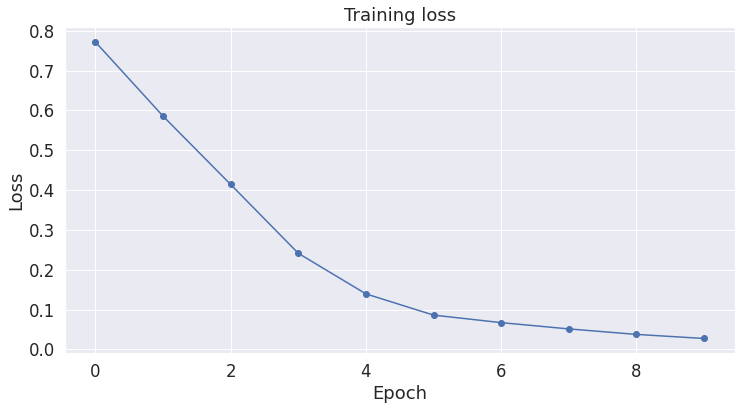

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
  y_true_val

[array([1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1]),
 array([1, 2, 0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 0, 1, 0, 2]),
 array([0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 1,
        2, 2, 0, 1, 2, 1, 1, 2, 2, 1]),
 array([0, 0, 1, 1, 2, 2, 2, 0, 1, 3, 1, 2, 0, 0, 1, 2, 2, 1, 2, 1, 2, 1,
        2, 2, 1, 2, 1, 2, 1, 2, 1, 2]),
 array([1, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 1, 1, 1]),
 array([2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1,
        1, 1, 0, 2, 2, 1, 1, 1, 2, 2]),
 array([2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 1, 0, 1, 2,
        1, 1, 2, 0, 1, 2, 2, 1, 2, 1]),
 array([0, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1,
        0, 2, 1, 1, 2, 2, 2, 1, 0, 2]),
 array([0, 0, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 2, 0, 1, 1,
        2, 1, 

In [ ]:
y_pred_val

[array([[-0.96065724, -1.7921594 ,  3.7307448 , -1.1333733 ],
        [-1.556782  ,  4.9894977 , -3.1774364 , -1.9142891 ],
        [-2.2958622 ,  4.382209  , -2.651717  , -1.7284626 ],
        [-2.5329735 ,  5.0075693 , -2.6596265 , -1.3641088 ],
        [-2.9663477 , -0.6544809 ,  5.72723   , -2.2043195 ],
        [-3.6027153 ,  4.823357  , -1.6875398 , -1.4212021 ],
        [-3.102503  ,  5.063776  , -2.4804924 , -1.1153337 ],
        [-2.7598927 , -0.92507106,  5.729737  , -1.9308497 ],
        [ 1.545713  , -1.5166773 ,  1.5797223 , -1.0896921 ],
        [ 1.4462425 ,  1.0439564 , -2.0250287 , -1.0666    ],
        [-2.705139  , -1.2914991 ,  5.9673324 , -1.7480018 ],
        [ 2.013622  ,  1.4244772 , -2.4682732 , -1.5458237 ],
        [ 1.9626266 , -1.6139867 ,  0.9515562 , -0.53597313],
        [-3.3445022 ,  5.045249  , -1.9341573 , -1.4576596 ],
        [-3.1447058 ,  5.2640767 , -2.1239934 , -1.6917446 ],
        [-2.6036003 , -1.1442623 ,  5.9019227 , -2.0942605 ],
        

In [ ]:
import sklearn.metrics as skm
import numpy as np

y_pred_val = np.concatenate(y_pred_val, axis=0) 
y_pred_val = np.argmax(y_pred_val, axis=1).flatten() 

y_true_val = np.concatenate(y_true_val, axis=0) 
# y_true_val = np.argmax(y_true_val, axis=1).flatten() x
# y_pred = np.concatenate((y_pred_train, y_pred_val), axis=None)

print(len(y_pred_val))
print(len(y_true_val))
cm = skm.multilabel_confusion_matrix(y_true_val, y_pred_val)
print(cm)
print( skm.classification_report(y_true_val, y_pred_val))

600
600
[[[503  44]
  [ 35  18]]

 [[254  75]
  [ 72 199]]

 [[277  49]
  [ 59 215]]

 [[598   0]
  [  2   0]]]
              precision    recall  f1-score   support

           0       0.29      0.34      0.31        53
           1       0.73      0.73      0.73       271
           2       0.81      0.78      0.80       274
           3       0.00      0.00      0.00         2

    accuracy                           0.72       600
   macro avg       0.46      0.46      0.46       600
weighted avg       0.73      0.72      0.72       600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Evaluate Model Performance
print('Training Accuracy :', model.score(X_train, y_train))  
print('Testing Accuracy :', model.score(y_true_val, y_pred_val))  

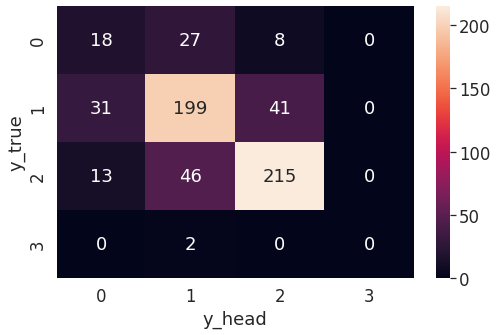

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true_val, y_pred_val), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

# Testing (Don't Run It)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        padding = 'max_length',
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 1

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Jumlah batch :', len(prediction_dataloader))

Jumlah batch : 13704


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []
i = 1
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
      print(i)
      i+=1

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

Streaming output truncated to the last 5000 lines.
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895

In [ ]:
predictions

[array([[-2.9733233,  5.1862445, -2.3523047, -1.4381895]], dtype=float32),
 array([[-2.5229497, -1.5718403,  6.0005646, -1.8152249]], dtype=float32),
 array([[ 0.8290695,  3.337191 , -3.577088 , -1.6239462]], dtype=float32),
 array([[ 3.8417065,  0.6320272, -3.085724 , -1.2199986]], dtype=float32),
 array([[-3.8372197,  4.941818 , -1.537505 , -1.1709651]], dtype=float32),
 array([[-1.0852433, -2.5056968,  5.4680796, -1.5074148]], dtype=float32),
 array([[-3.3500166 , -0.35527682,  5.4750743 , -1.9319496 ]],
       dtype=float32),
 array([[-3.220327  , -0.16064805,  5.3338833 , -2.2043648 ]],
       dtype=float32),
 array([[-3.913984 ,  0.7473988,  4.8297014, -2.094876 ]], dtype=float32),
 array([[-3.1833053,  4.9537206, -2.430178 , -1.3266845]], dtype=float32),
 array([[-2.5806844, -1.1282495,  5.456759 , -2.132004 ]], dtype=float32),
 array([[-2.6281219, -0.5974927,  5.1677904, -1.7423784]], dtype=float32),
 array([[-2.4752696, -1.0282235,  5.570598 , -2.1033895]], dtype=float32),
 ar

In [ ]:
np.shape(predictions)

(13704, 1, 4)

In [ ]:
predictions = np.concatenate(predictions, axis=0)

In [ ]:
data_result = pd.DataFrame(predictions, columns=['PRO VAKSIN', 'NETRAL', 'RAGU RAGU','ANTI VAKSIN'])

In [ ]:
dfhasilpredict = data_result.eq(data_result.where(data_result != 0).max(1), axis=0).astype(int)
dfhasilpredict

,PRO VAKSIN,NETRAL,RAGU RAGU,ANTI VAKSIN
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,1,0,0,0
4,0,1,0,0
...,...,...,...,...
13699,0,1,0,0
13700,0,0,1,0
13701,0,0,1,0
13702,0,0,1,0


In [ ]:
check = pd.read_csv('/content/drive/MyDrive/penelitian/data4/dataset/dataset_jenis vaksin_prokontra_fix.csv').drop(columns=['response','Unnamed: 0'])
check

In [ ]:
testdata

,id,date,username,tweet,replies_count,retweets_count,likes_count,link,tweet_preprocessed,labels,NEUTRAL,POSITIVE,NEGATIVE
0,1416283768197763072,2021-07-17,effendisimbolo3,@adearmando1 Vaksinasi segera dikebut secepatn...,0,0,0,https://twitter.com/effendisimbolo3/status/141...,adearmando1 vaksinasi segera dikebut secepatny...,jenis,0,1,0
1,1419855062063534080,2021-07-27,keepodotme,"Inilah Perbedaan Vaksin Sinovac, Astrazeneca, ...",0,3,0,https://twitter.com/KeepoDotMe/status/14198550...,inilah perbedaan vaksin sinovac astrazeneca mo...,jenis,1,0,0
2,1418526310456978944,2021-07-23,reborn21s,Saya sih lebih percaya vaksin Nusantara buatan...,1,0,0,https://twitter.com/Reborn21s/status/141852631...,sih lebih percaya vaksin nusantara buatan anak...,jenis,0,1,0
3,1416944954073513984,2021-07-19,anjody17,"@SSyahri04520464 Lebih murah vaksin nusantara,...",1,0,1,https://twitter.com/anjody17/status/1416944954...,ssyahri04520464 lebih murah vaksin nusantara h...,jenis,0,1,0
4,1425645524347019008,2021-08-12,fadhillahaisya3,Akhirnya saya selesai vaksin dosis ke 3 untuk ...,17,24,243,https://twitter.com/FadhillahAisya3/status/142...,akhirnya selesai vaksin dosis 3 tenaga medis s...,jenis,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13699,1405699936126001153,2021-06-18,bacautas,"Haloo @blue_adamant 😃👋 Selamat membaca! ""Sudah...",0,0,1,https://twitter.com/bacautas/status/1405699936...,haloo blueadamant selamat membaca divaksinasi ...,jenis,1,0,0
13700,1337175463672897539,2020-12-10,mazrieva,Badan Urusan Pangan &amp; Obat2an Amerika FDA ...,0,0,1,https://twitter.com/mazrieva/status/1337175463...,badan urusan pangan amp obat2an amerika fda di...,jenis,1,0,0
13701,1414227765105070083,2021-07-11,laju_petang,Kemudian AstraZeneca dukungan dose sharing bil...,1,0,0,https://twitter.com/Laju_peTang/status/1414227...,kemudian astrazeneca dukungan dose sharing bil...,jenis,1,0,0
13702,1421100833240797185,2021-07-30,basukining,@OposisiCerdas Lho kok vaksin nusantara,0,0,0,https://twitter.com/basukining/status/14211008...,oposisicerdas lho kok vaksin nusantara,jenis,0,1,0


In [ ]:
finalresult = pd.concat([testdata, dfhasilpredict], axis=1, sort=False)
finalresult

,id,date,username,tweet,replies_count,retweets_count,likes_count,link,tweet_preprocessed,labels,NEUTRAL,POSITIVE,NEGATIVE,PRO VAKSIN,NETRAL,RAGU RAGU,ANTI VAKSIN
0,1416283768197763072,2021-07-17,effendisimbolo3,@adearmando1 Vaksinasi segera dikebut secepatn...,0,0,0,https://twitter.com/effendisimbolo3/status/141...,adearmando1 vaksinasi segera dikebut secepatny...,jenis,0,1,0,0,1,0,0
1,1419855062063534080,2021-07-27,keepodotme,"Inilah Perbedaan Vaksin Sinovac, Astrazeneca, ...",0,3,0,https://twitter.com/KeepoDotMe/status/14198550...,inilah perbedaan vaksin sinovac astrazeneca mo...,jenis,1,0,0,0,0,1,0
2,1418526310456978944,2021-07-23,reborn21s,Saya sih lebih percaya vaksin Nusantara buatan...,1,0,0,https://twitter.com/Reborn21s/status/141852631...,sih lebih percaya vaksin nusantara buatan anak...,jenis,0,1,0,0,1,0,0
3,1416944954073513984,2021-07-19,anjody17,"@SSyahri04520464 Lebih murah vaksin nusantara,...",1,0,1,https://twitter.com/anjody17/status/1416944954...,ssyahri04520464 lebih murah vaksin nusantara h...,jenis,0,1,0,1,0,0,0
4,1425645524347019008,2021-08-12,fadhillahaisya3,Akhirnya saya selesai vaksin dosis ke 3 untuk ...,17,24,243,https://twitter.com/FadhillahAisya3/status/142...,akhirnya selesai vaksin dosis 3 tenaga medis s...,jenis,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13699,1405699936126001153,2021-06-18,bacautas,"Haloo @blue_adamant 😃👋 Selamat membaca! ""Sudah...",0,0,1,https://twitter.com/bacautas/status/1405699936...,haloo blueadamant selamat membaca divaksinasi ...,jenis,1,0,0,0,1,0,0
13700,1337175463672897539,2020-12-10,mazrieva,Badan Urusan Pangan &amp; Obat2an Amerika FDA ...,0,0,1,https://twitter.com/mazrieva/status/1337175463...,badan urusan pangan amp obat2an amerika fda di...,jenis,1,0,0,0,0,1,0
13701,1414227765105070083,2021-07-11,laju_petang,Kemudian AstraZeneca dukungan dose sharing bil...,1,0,0,https://twitter.com/Laju_peTang/status/1414227...,kemudian astrazeneca dukungan dose sharing bil...,jenis,1,0,0,0,0,1,0
13702,1421100833240797185,2021-07-30,basukining,@OposisiCerdas Lho kok vaksin nusantara,0,0,0,https://twitter.com/basukining/status/14211008...,oposisicerdas lho kok vaksin nusantara,jenis,0,1,0,0,0,1,0


In [ ]:
# from google.colab import files
finalresult.to_csv('/content/drive/MyDrive/penelitian/data5/data provaks/result_jenisvaksin.csv', index=False) 
# files.download('reply_test_18juli_result_sentiment_IndoBERT(IndoNLU).csv')

#Save Model

In [ ]:
filepath = '/content/drive/MyDrive/penelitian/data5/model/indobertindobenchmarksentiment_provaks.pth'
# torch.save(model, filepath)

#Eval Data New Datase (Run)

In [ ]:
# Then later:
model = torch.load(filepath)

In [ ]:
predict_data = pd.read_csv("/content/drive/MyDrive/penelitian/data5/data label fix/efeksamping_sentiment.csv")

## TWEET DATA

In [ ]:
predict_sentences_tweet = predict_data['tweet'].values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = [] 
 
# For every sentence...
for sent in predict_sentences_tweet: 
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        padding = 'max_length',
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Jumlah batch :', len(prediction_dataloader))

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

In [ ]:
predictions

In [ ]:
np.shape(predictions)

In [ ]:
predictions = np.concatenate(predictions, axis=0)

In [ ]:
data_result = pd.DataFrame(predictions, columns=['TWEET NEUTRAL', 'TWEET POSITIVE', 'TWEET NEGATIVE'])

In [ ]:
dfhasilpredict = data_result.eq(data_result.where(data_result != 0).max(1), axis=0).astype(int)
dfhasilpredict

In [ ]:
finalresult = pd.concat([predict_data, dfhasilpredict], axis=1, sort=False)
finalresult

In [ ]:
from google.colab import files
finalresult.to_csv('reply_test_1agustus_result_sentiment_IndoBERT(IndoNLU).csv', index= False) 
# files.download('reply_test_18juli_result_sentiment_IndoBERT(IndoNLU).csv')

## TEXT REPLY DATA

In [ ]:
predict_data = pd.read_csv("/content/drive/MyDrive/penelitian/data5/data label fix/efektivitas_clean_nostem.csv")

In [ ]:
predict_data

,id,date,username,tweet,replies_count,retweets_count,likes_count,link,tweet_preprocessed,labels,moderna,astra,pfizer,sinovac,nusantara,NEUTRAL,POSITIVE,NEGATIVE
0,1426131585057792002,2021-08-13,karetbetet,"@DivHumas_Polri Yuk, terapkan protokol kesehat...",0,0,0,https://twitter.com/KaretBetet/status/14261315...,divhumaspolri yuk terapkan protokol kesehatan ...,efektivitas,0,0,0,0,0,0,1,0
1,1425428077400629250,2021-08-11,karetbetet,@DivHumas_Polri Vaksinasi Covid-19 dapat meran...,0,0,0,https://twitter.com/KaretBetet/status/14254280...,divhumaspolri vaksinasi covid19 merangsang sis...,efektivitas,0,0,0,0,0,0,1,0
2,1425001122746408964,2021-08-10,polresbutur,Ayo Vaksin ! Vaksinasi Covid-19 ...,0,0,0,https://twitter.com/PolresButur/status/1425001...,ayo vaksin vaksinasi covid19 merangsang sistem...,efektivitas,0,0,0,0,0,0,1,0
3,1424612700781383687,2021-08-09,infokomjaksel,"Senin 09 Agustus 2021, Dalam rangka memperkuat...",1,6,7,https://twitter.com/InfokomJakSel/status/14246...,senin 09 agustus 2021 rangka memperkuat kekeba...,efektivitas,0,0,0,0,0,1,0,0
4,1424608542191874053,2021-08-09,nayangasa,Vaksinasi adlh cara kita utk menekan angka pen...,0,0,0,https://twitter.com/nayangasa/status/142460854...,vaksinasi adalah cara untuk menekan angka penu...,efektivitas,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,1407588454360227841,2021-06-23,matapolitikcom,Otoritas kesehatan India menyebut mutasi COVID...,0,0,0,https://twitter.com/matapolitikcom/status/1407...,otoritas kesehatan india menyebut mutasi covid...,efektivitas,0,0,0,0,0,1,0,0
782,1407242854775152642,2021-06-22,forkompi,WHO baru-baru ini juga mengelompokkan B.1.617 ...,1,0,2,https://twitter.com/Forkompi/status/1407242854...,who barubaru juga mengelompokkan b1617 variant...,efektivitas,0,0,0,0,0,1,0,0
783,1404759077658390530,2021-06-15,narasinewsroom,104 dari 145 kasus mutasi virus corona yang te...,1,6,24,https://twitter.com/NarasiNewsroom/status/1404...,104 145 kasus mutasi virus corona tergolong va...,efektivitas,0,0,0,0,0,1,0,0
784,1394223415158927360,2021-05-17,fitradiobandung,Waspada varian baru Corona memiliki penularan ...,0,0,0,https://twitter.com/FitRadioBandung/status/139...,waspada varian baru corona memiliki penularan ...,efektivitas,0,0,0,0,0,1,0,0


In [ ]:
predict_sentences_reply = predict_data['tweet_preprocessed'].values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in predict_sentences_reply:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        padding = 'max_length',
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 1

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Jumlah batch :', len(prediction_dataloader))

Jumlah batch : 786


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

Predicting labels for 786 test sentences...
    DONE.


In [ ]:
predictions

[array([[-3.680217 ,  4.7707367, -0.9855027, -1.7409166]], dtype=float32),
 array([[-3.901622 ,  4.454714 , -0.2486372, -2.3009112]], dtype=float32),
 array([[-4.3072166,  2.449927 ,  3.3186524, -1.9247451]], dtype=float32),
 array([[-3.9740088,  1.9941732,  3.128976 , -2.2400734]], dtype=float32),
 array([[-3.5732462,  4.9980474, -1.5512449, -1.7843112]], dtype=float32),
 array([[-4.3663526,  3.3211014,  2.1393914, -2.4993186]], dtype=float32),
 array([[-4.012617  ,  4.641142  , -0.37037888, -2.0332599 ]],
       dtype=float32),
 array([[-4.254377 ,  2.4801424,  3.065085 , -2.3400328]], dtype=float32),
 array([[-3.901622 ,  4.454714 , -0.2486372, -2.3009112]], dtype=float32),
 array([[-3.823258  ,  4.037226  , -0.20201285, -1.9577063 ]],
       dtype=float32),
 array([[-3.823258  ,  4.037226  , -0.20201285, -1.9577063 ]],
       dtype=float32),
 array([[-3.2112198, -0.3185876,  5.3734117, -2.1622868]], dtype=float32),
 array([[-4.1964493,  2.3271441,  3.3132925, -2.5784614]], dtype=fl

In [ ]:
np.shape(predictions)

(786, 1, 4)

In [ ]:
predictions = np.concatenate(predictions, axis=0)

In [ ]:
data_result = pd.DataFrame(predictions, columns=['PRO VAKSIN', 'NETRAL', 'RAGU RAGU','ANTI VAKSIN'])

In [ ]:
dfhasilpredict = data_result.eq(data_result.where(data_result != 0).max(1), axis=0).astype(int)
dfhasilpredict

,PRO VAKSIN,NETRAL,RAGU RAGU,ANTI VAKSIN
0,0,1,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,1,0,0
...,...,...,...,...
781,0,0,1,0
782,0,0,1,0
783,0,0,1,0
784,0,0,1,0


In [ ]:
finalresult = pd.concat([predict_data, dfhasilpredict], axis=1, sort=False)
finalresult

,id,date,username,tweet,replies_count,retweets_count,likes_count,link,tweet_preprocessed,labels,moderna,astra,pfizer,sinovac,nusantara,NEUTRAL,POSITIVE,NEGATIVE,PRO VAKSIN,NETRAL,RAGU RAGU,ANTI VAKSIN
0,1426131585057792002,2021-08-13,karetbetet,"@DivHumas_Polri Yuk, terapkan protokol kesehat...",0,0,0,https://twitter.com/KaretBetet/status/14261315...,divhumaspolri yuk terapkan protokol kesehatan ...,efektivitas,0,0,0,0,0,0,1,0,0,1,0,0
1,1425428077400629250,2021-08-11,karetbetet,@DivHumas_Polri Vaksinasi Covid-19 dapat meran...,0,0,0,https://twitter.com/KaretBetet/status/14254280...,divhumaspolri vaksinasi covid19 merangsang sis...,efektivitas,0,0,0,0,0,0,1,0,0,1,0,0
2,1425001122746408964,2021-08-10,polresbutur,Ayo Vaksin ! Vaksinasi Covid-19 ...,0,0,0,https://twitter.com/PolresButur/status/1425001...,ayo vaksin vaksinasi covid19 merangsang sistem...,efektivitas,0,0,0,0,0,0,1,0,0,0,1,0
3,1424612700781383687,2021-08-09,infokomjaksel,"Senin 09 Agustus 2021, Dalam rangka memperkuat...",1,6,7,https://twitter.com/InfokomJakSel/status/14246...,senin 09 agustus 2021 rangka memperkuat kekeba...,efektivitas,0,0,0,0,0,1,0,0,0,0,1,0
4,1424608542191874053,2021-08-09,nayangasa,Vaksinasi adlh cara kita utk menekan angka pen...,0,0,0,https://twitter.com/nayangasa/status/142460854...,vaksinasi adalah cara untuk menekan angka penu...,efektivitas,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,1407588454360227841,2021-06-23,matapolitikcom,Otoritas kesehatan India menyebut mutasi COVID...,0,0,0,https://twitter.com/matapolitikcom/status/1407...,otoritas kesehatan india menyebut mutasi covid...,efektivitas,0,0,0,0,0,1,0,0,0,0,1,0
782,1407242854775152642,2021-06-22,forkompi,WHO baru-baru ini juga mengelompokkan B.1.617 ...,1,0,2,https://twitter.com/Forkompi/status/1407242854...,who barubaru juga mengelompokkan b1617 variant...,efektivitas,0,0,0,0,0,1,0,0,0,0,1,0
783,1404759077658390530,2021-06-15,narasinewsroom,104 dari 145 kasus mutasi virus corona yang te...,1,6,24,https://twitter.com/NarasiNewsroom/status/1404...,104 145 kasus mutasi virus corona tergolong va...,efektivitas,0,0,0,0,0,1,0,0,0,0,1,0
784,1394223415158927360,2021-05-17,fitradiobandung,Waspada varian baru Corona memiliki penularan ...,0,0,0,https://twitter.com/FitRadioBandung/status/139...,waspada varian baru corona memiliki penularan ...,efektivitas,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
from google.colab import files
finalresult.to_csv('reply_test_1agustus_result_sentiment_IndoBERT(IndoNLU).csv', index= False) 
files.download('reply_test_1agustus_result_sentiment_IndoBERT(IndoNLU).csv')

In [ ]:
finalresult.to_csv('/content/drive/MyDrive/penelitian/data5/data provaks/result_efektivitas.csv')